In [1]:
cpu_count = 100
import os
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={cpu_count}'
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
from jax import pmap, tree_map
import jax
import pandas as pd
from scipy.stats.qmc import LatinHypercube
from scipy.stats import expon

In [5]:
n_chains = 10

In [6]:
key = random.PRNGKey(42)

In [7]:
def full_solution(params, eir, eta):
    p = dmeq.default_parameters()
    for k, v in params.items():
        p[k] = v
    p['EIR'] = eir
    p['eta'] = eta
    return dmeq.solve(p, dtype=jnp.float64)

In [8]:
population = 1_000_000
prev_N = 1_000

def prev_stats(params, eir, eta, impl=full_solution):
    solution = impl(params, eir, eta)
    inc_rates = solution[1] * solution[-1] * population
    return (
        jnp.array([
            solution[0, 3:10].sum() / solution[-1, 3:10].sum(), # Prev 2 - 10
            solution[0, 10:].sum() / solution[-1, 10:].sum(), # Prev 10+
        ]),
        jnp.array([
            inc_rates[:5].sum(), # Inc 0 - 5
            inc_rates[5:15].sum(), # Inc 5 - 15
            inc_rates[15:].sum() # Inc 15+
        ])
    )

In [9]:
prev_stats_multisite = vmap(prev_stats, in_axes=[None, 0, 0, None])

In [10]:
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
key, key_i = random.split(key)
etas = 1. / random.uniform(key_i, shape=EIRs.shape, minval=20*365, maxval=40*365, dtype=jnp.float64)

In [11]:
def without_obs(params):
    return {k : v for k, v in params.items() if not k in {'obs_inc', 'obs_prev'}}

In [54]:
train_samples = int(3 * 1e5)
device_count = len(jax.devices())

In [55]:
model_params = [
    'kb',
    'ub',
    'b0',
    'IB0',
    'kc',
    'uc',
    'IC0',
    'phi0',
    'phi1',
    'PM',
    'dm',
    'kd',
    'ud',
    'd1',
    'ID0',
    'fd0',
    'gd',
    'ad0',
    'rU',
    'cD',
    'cU',
    'g_inf'
]
_, x_def = jax.tree_util.tree_flatten(
    {k:v for k, v in dmeq.default_parameters().items() if k in model_params}
)

In [56]:
# TODO: this translation is messy for no reason

In [57]:
# Create the X_lhs dataset
bounds = pd.DataFrame.from_records([
    ('kb', 0, 10),
    ('ub', 0, 10),
    ('b0', 0, 1),
    ('IB0', 0, 100),
    ('kc', 0, 10),
    ('uc', 0, 10),
    ('IC0', 0, 200),
    ('phi0', 0, 1),
    ('phi1', 0, 1),
    ('PM', 0, 1),
    ('dm', 0, 500),
    ('kd', .01, 10),
    ('ud', 0, 10),
    ('d1', 0, 1),
    ('ID0', 0, 100),
    ('fd0', 0, 1),
    ('gd', 0, 10),
    ('ad0', 20 * 365, 40 * 365),
    ('rU', 0, 500),
    ('cD', 0, 1),
    ('cU', 0, 1),
    ('g_inf', 0, 10)
], columns=['name', 'lower', 'upper'])

sampler = LatinHypercube(d=len(bounds), seed=42)
samples = sampler.random(train_samples)
ordered_bounds = bounds.set_index('name').loc[pd.Series(model_params)]

X_lhs = samples * (
    ordered_bounds.upper - ordered_bounds.lower
).to_numpy() + ordered_bounds.lower.to_numpy()

In [58]:
# Sample site parameters
import numpy as np
site_bounds = pd.DataFrame.from_records([
    ('EIR', 0., 500.),
    ('eta', 1/(40 * 365), 1/(20 * 365))
], columns=['name', 'lower', 'upper'])
site_sampler = LatinHypercube(d=len(site_bounds), seed=42)
X_site = site_sampler.random(train_samples)
# sample EIR (.2) from exponential distribution and (.8) from uniform
#site_sample_split = int(X_site.shape[0] * .2)
#eir_samples = np.concatenate([
#    expon(0, 10).ppf(X_site[:site_sample_split,0]),
#    X_site[site_sample_split:,0] * 500.
#])
#X_site[:,0] = eir_samples
# sample ETA from uniform
#X_site[:,1] = X_site[:,1] * (1/(20 * 365) - 1/(40 * 365)) + 1/(40 * 365)
#X_site = X_site[np.random.permutation(X_site.shape[0]),:]
X_site = X_site * (site_bounds.upper - site_bounds.lower).to_numpy() + site_bounds.lower.to_numpy()

In [93]:
# Sample full y
def sample_full_y(x, x_site):
    params = jax.tree_util.tree_unflatten(x_def, x)
    return full_solution(params, x_site[0], x_site[1])

def sample_y_from_x(x, x_site, impl):
    y = pmap(vmap(impl), devices=jax.devices('cpu'))(
        jnp.reshape(x, (cpu_count, x.shape[0] // cpu_count,) + x.shape[1:]),
        jnp.reshape(x_site, (cpu_count, x_site.shape[0] // cpu_count,) + x_site.shape[1:])
    )
    y_shape = y.shape[2:]
    return (jnp.reshape(y, (x.shape[0],) + y_shape), y_shape)

y_lhs_full, y_shape = sample_y_from_x(X_lhs, X_site, sample_full_y)

In [61]:
def split(x, split):
    return (x[:split], x[split:])

val_split = int(train_samples/3)

def standardise(x, mean, std):
    return (x - mean) / std

def inverse_standardise(x, mean, std):
    return x * std + mean

def summarise(x, axis):
    return jnp.mean(x, axis=axis, keepdims=True), jnp.std(x, axis=axis, keepdims=True)

def adapt(x, axis):
    mean, std = summarise(x, axis)
    return (standardise(x, mean, std), mean, std)

datasets = {
    'X_lhs': X_lhs,
    'X_site': X_site,
    'y_lhs_full': y_lhs_full
    # 'y_lhs_full': (y_lhs_full, 0),
}

In [20]:
from flax import linen as nn
from jax.nn import softplus
import optax
from jax import value_and_grad
from jaxtyping import Array

In [21]:
def minmaxrelu(x, min_x, max_x):
    '''relu with a min and max'''
    x = jnp.maximum(x, min_x)
    return jnp.minimum(x, max_x)

class MaskedMinMaxSurrogate(nn.Module):
    units: int
    n_hidden: int
    n_output: int
    y_min: Array
    y_max: Array

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.units) for _ in range(self.n_hidden)]
        for i, lyr in enumerate(layers):
            x = lyr(x)
            x = nn.relu(x)
        x = nn.Dense(self.n_output)(x)
        return minmaxrelu(x, self.y_min, self.y_max)

def l2_loss(x, alpha):
    return alpha * (x ** 2).mean()

def log_cosh(model, params, x_batched, y_batched):
    # Define a numerically stable log cosh for a single pair (x,y)
    def error(x, y):
        pred = model.apply(params, x)
        diff = y - pred
        return jnp.mean(diff + softplus(-2 * diff) - jnp.log(2.))

    # Regularisation loss
    reg_loss = sum(
        l2_loss(w, alpha=0.001)
        for w in jax.tree_util.tree_leaves(params)
    )

    # Vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(vmap(error)(x_batched, y_batched), axis=0) + reg_loss

In [22]:
def make_surrogate(key, X, y, y_shape):
    y, y_mean, y_std = adapt(y, (0, 2))
    X, X_mean, X_std = adapt(X, 0)
    surrogate_model = MaskedMinMaxSurrogate(
        units=288,
        n_hidden=3,
        n_output=jnp.product(jnp.array(y_shape)),
        y_min=standardise(jnp.zeros(y_shape), y_mean, y_std)[0].reshape(-1),
        y_max=standardise(jnp.ones(y_shape), y_mean, y_std)[0].reshape(-1)
    )
    surrogate_params = surrogate_model.init(key, X)

    tx = optax.adam(learning_rate=.001)
    opt_state = tx.init(surrogate_params)
    loss_grad_fn = value_and_grad(jit(lambda p, x, y: log_cosh(surrogate_model, p, x, y)))

    batch_size = 100

    n_batches = X.shape[0] // batch_size
    X_batched = jnp.reshape(X, (n_batches, batch_size, -1))
    y_batched = jnp.reshape(y, (n_batches, batch_size, -1))

    epochs = 100
    
    for i in range(epochs):
        key, key_i = random.split(key)
        
        for b in random.permutation(key_i, n_batches, independent=True):
            loss_val, grads = loss_grad_fn(
                surrogate_params,
                X_batched[b],
                y_batched[b]
            )
            updates, opt_state = tx.update(grads, opt_state)
            surrogate_params = optax.apply_updates(surrogate_params, updates)

    return (surrogate_model, surrogate_params, X_mean, X_std, y_mean, y_std)

In [66]:
def make_full_surrogate(key, x, x_site, y):
    X = jnp.concatenate([x_site, x], axis=1)
    return make_surrogate(
        key,
        X,
        y,
        y_shape
    )

In [62]:
n_sample_points = 10

def subsample(d, sample_size):
    return {k: v[:sample_size] for k, v in datasets.items()}

def surrogate_for_sample_size(key_i, sample_size):
    print('sample_size:', sample_size)
    d = subsample(datasets, sample_size)
    
    return make_full_surrogate(
        key_i,
        d['X_lhs'],
        d['X_site'],
        d['y_lhs_full']
    )

In [25]:
key, *key_i = random.split(key, num=n_sample_points + 1)
sample_points = jnp.linspace(1000, train_samples / 3, num=n_sample_points, dtype=jnp.int64)
surrogates = [
    surrogate_for_sample_size(key, sample_size)
    for key, sample_size in
    list(zip(key_i, sample_points))
]

sample_size: 1000
sample_size: 12000
sample_size: 23000
sample_size: 34000
sample_size: 45000
sample_size: 56000
sample_size: 67000
sample_size: 78000
sample_size: 89000
sample_size: 100000


In [109]:
y_val = datasets['y_lhs_full'][val_split:2*val_split]

def mses(y, y_hat):
    diff = y - y_hat
    return jnp.mean(jnp.square(diff), axis=(1,2))

def predict(model, params, X):
    def f(x):
        return model.apply(params, x)
    return vmap(f)(X)

def validate(surrogate, y_shape):
    model, params, X_mean, X_std, y_mean, y_std = surrogate
    x_val = jnp.concatenate([
       datasets['X_site'][val_split:2*val_split],
       datasets['X_lhs'][val_split:2*val_split] # validation
    ], axis=1)
    x_val_stand = standardise(x_val, X_mean, X_std)
    return mses(
        standardise(y_val, y_mean, y_std)[:,0:1,:],
        predict(model, params, x_val_stand).reshape((x_val_stand.shape[0],) + y_shape)[:,0:1,:]
    )

#y_hats = [validate(s) for s in surrogates]
#losses = [mses(datasets['y_lhs_full'][1], y_hat) for y_hat in y_hats]

In [68]:
full_losses = [validate(s['full'], y_shape) for s in surrogates]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f09a07326b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f09a07334f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f09a0731ae0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f09a0731fc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f09a0732f80>,
 'means': []}

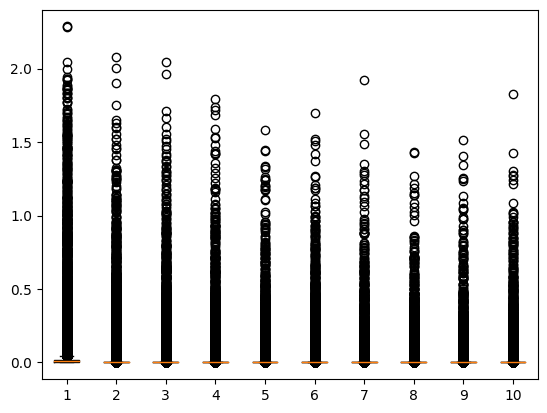

In [69]:
plt.boxplot(full_losses)

In [126]:
a_losses = validate(a_surrogate, y_shape)

In [129]:
np.max(full_losses[0]), np.max(a_losses)

(Array(2.28625585, dtype=float64), Array(2.13012389, dtype=float64))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f097c1d8940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f08802ebc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f097c1d9690>],
 'medians': [<matplotlib.lines.Line2D at 0x7f08802ea7d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f08802e8640>],
 'means': []}

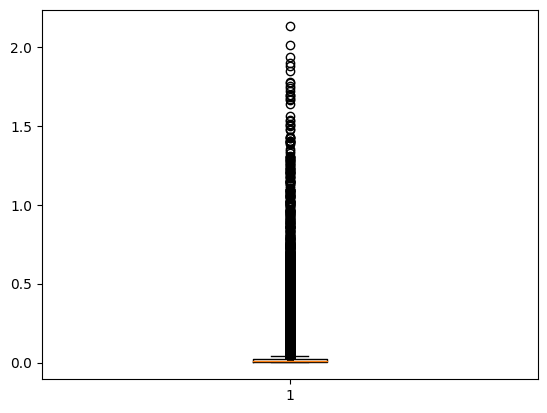

In [128]:
plt.boxplot(a_losses)

# TODO:

 * sampling setup 1e5 pool
   * sample highest loss with gaussian
   * gradient descent
 * metric
   * ensemble uncertainty
 * plot worst errors

In [133]:
def sample_high_loss(surrogate, pool, sample_size, key, ratio=1/50, sigma=1e-3):
    # calculate loss vector
    model, params, X_mean, X_std, y_mean, y_std = surrogate
    X = jnp.concatenate([pool['X_site'], pool['X_lhs']], axis=1)
    X = standardise(X, X_mean, X_std)
    loss = mses(
        standardise(pool['y_lhs_full'], y_mean, y_std)[:,0:1,:],
        predict(model, params, X).reshape((X.shape[0],) + y_shape)[:,0:1,:]
    )
    
    # calculate candidates from ratio
    candidates = jnp.where(loss > jnp.quantile(loss, 1 - ratio))[0]
    
    # sample new points from gaussian (truncated by bounds)
    key, key_i = random.split(key)
    X = X[random.choice(key_i, candidates, (sample_size,), replace=True)]
    
    X_bounds = standardise(
        jnp.stack([
            jnp.concatenate([site_bounds.lower.values, ordered_bounds.lower.values]),
            jnp.concatenate([site_bounds.upper.values, ordered_bounds.upper.values])
        ]),
        X_mean,
        X_std
    )
    X_lower = jnp.repeat(X_bounds[0:1], X.shape[0], axis=0) - X
    X_upper = jnp.repeat(X_bounds[1:2], X.shape[0], axis=0) - X
    key, key_i = random.split(key)
    X = inverse_standardise(
        random.truncated_normal(key_i, X_lower, X_upper) * sigma + X,
        X_mean,
        X_std
    )
    
    # Calculate y
    X_lhs, X_site = X[:,2:], X[:,:2]
    
    y_lhs_full, _ = sample_y_from_x(X_lhs, X_site, sample_full_y)
    
    return {
        'X_lhs': X_lhs,
        'X_site': X_site,
        'y_lhs_full': y_lhs_full
    }

def sample_adjoint(surrogate, pool, sample_size, leaning_rate=1e-3, steps=100):
    # vectorise pool
    
    # for step in steps
    # calculate loss vector
    # calculate gradient
    # update pool
    
    # turn pool into dataset object 
    
    return pool

def subsample_pool(d, sample_size):
    return {k: v[2*val_split:2*val_split+sample_size] for k, v in datasets.items()}

def combine_datasets(a, b):
    return {k: jnp.concatenate([a[k], b[k]]) for k, v in b.items()}

def adaptive_surrogate_for_sample_size(surrogate, key, sample_size):
    print('sample_size:', sample_size)
    d = subsample(datasets, sample_size)
    pool = subsample_pool(datasets, sample_size)
    key, key_i = random.split(key) 
    pool = sample_high_loss(surrogate, pool, sample_size, key_i)
    dc = combine_datasets(d, pool)

    return make_full_surrogate(
        key,
        dc['X_lhs'],
        dc['X_site'],
        dc['y_lhs_full']
    )

In [134]:
a_surrogates = [
    adaptive_surrogate_for_sample_size(surrogate['full'], key, sample_size)
    for key, sample_size, surrogate in
    zip(key_i, sample_points, surrogates)
]

sample_size: 1000
sample_size: 12000
sample_size: 23000
sample_size: 34000
sample_size: 45000
sample_size: 56000
sample_size: 67000
sample_size: 78000
sample_size: 89000
sample_size: 100000


In [135]:
a_losses = [validate(s, y_shape) for s in a_surrogates]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f08204b0fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f08204b20b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0954386440>,
 'medians': [<matplotlib.lines.Line2D at 0x7f08204b1180>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f08204b04f0>,
 'means': []}

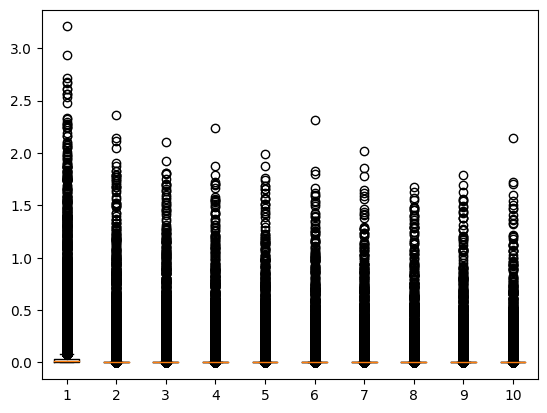

In [136]:
plt.boxplot(a_losses)

In [137]:
[np.mean(l) for l in a_losses]

[Array(0.03689363, dtype=float64),
 Array(0.00894691, dtype=float64),
 Array(0.00710241, dtype=float64),
 Array(0.00606021, dtype=float64),
 Array(0.00534898, dtype=float64),
 Array(0.00513629, dtype=float64),
 Array(0.00463975, dtype=float64),
 Array(0.00437427, dtype=float64),
 Array(0.00407204, dtype=float64),
 Array(0.00396104, dtype=float64)]

In [138]:
[np.mean(l) for l in full_losses]

[Array(0.02324262, dtype=float64),
 Array(0.00650143, dtype=float64),
 Array(0.00530787, dtype=float64),
 Array(0.004636, dtype=float64),
 Array(0.00360885, dtype=float64),
 Array(0.00375633, dtype=float64),
 Array(0.00296262, dtype=float64),
 Array(0.0030324, dtype=float64),
 Array(0.00256621, dtype=float64),
 Array(0.00256731, dtype=float64)]

In [125]:
a_surrogate = adaptive_surrogate_for_sample_size(
    surrogates[0]['full'],
    key,
    1000
)

sample_size: 1000


In [173]:
loss_data = pd.concat([
    pd.DataFrame(x_val, columns=['EIR', 'eta'] + list(without_obs(prior).keys())),
    pd.DataFrame(losses, columns=['mse_prev', 'mse_inc', 'mse_b','mse_c','mse_q', 'mse_prop'])
], axis=1)

In [ ]:
def sample_extra(n, X_site_mean, X_site_std, X_mean, X_std):
    X_site = site_sampler.random(n)
    X_site = X_site * (site_bounds.upper - site_bounds.lower).to_numpy() + site_bounds.lower.to_numpy()
    X_site = standardise(X_site, X_site_mean, X_site_std)
    X_lhs = sampler.random(n)
    X_lhs = samples * (
        ordered_bounds.upper - ordered_bounds.lower
    ).to_numpy() + ordered_bounds.lower.to_numpy()
    X_lhs = standardise(X_lhs, X_mean, X_std)
    return np.concatenate([X_site, X_lhs])


def update_surrogate(key, surrogate_model, surrogate_params, X, X_val, y, y_shape): # TODO
    y, y_val, y_mean, y_std = y

    tx = optax.adam(learning_rate=.001)
    opt_state = tx.init(surrogate_params)
    loss_grad_fn = value_and_grad(jit(lambda p, x, y: log_cosh(surrogate_model, p, x, y)))

    batch_size = 100

    n_batches = X.shape[0] // batch_size
    X_batched = jnp.reshape(X, (n_batches, batch_size, -1))
    y_batched = jnp.reshape(y, (n_batches, batch_size, -1))

    epochs = 100
    
    for i in range(epochs):
        key, key_i = random.split(key)
        
        for b in random.permutation(key_i, n_batches, independent=True):
            loss_val, grads = loss_grad_fn(
                surrogate_params,
                X_batched[b],
                y_batched[b]
            )
            updates, opt_state = tx.update(grads, opt_state)
            surrogate_params = optax.apply_updates(surrogate_params, updates)

    return (surrogate_model, surrogate_params)

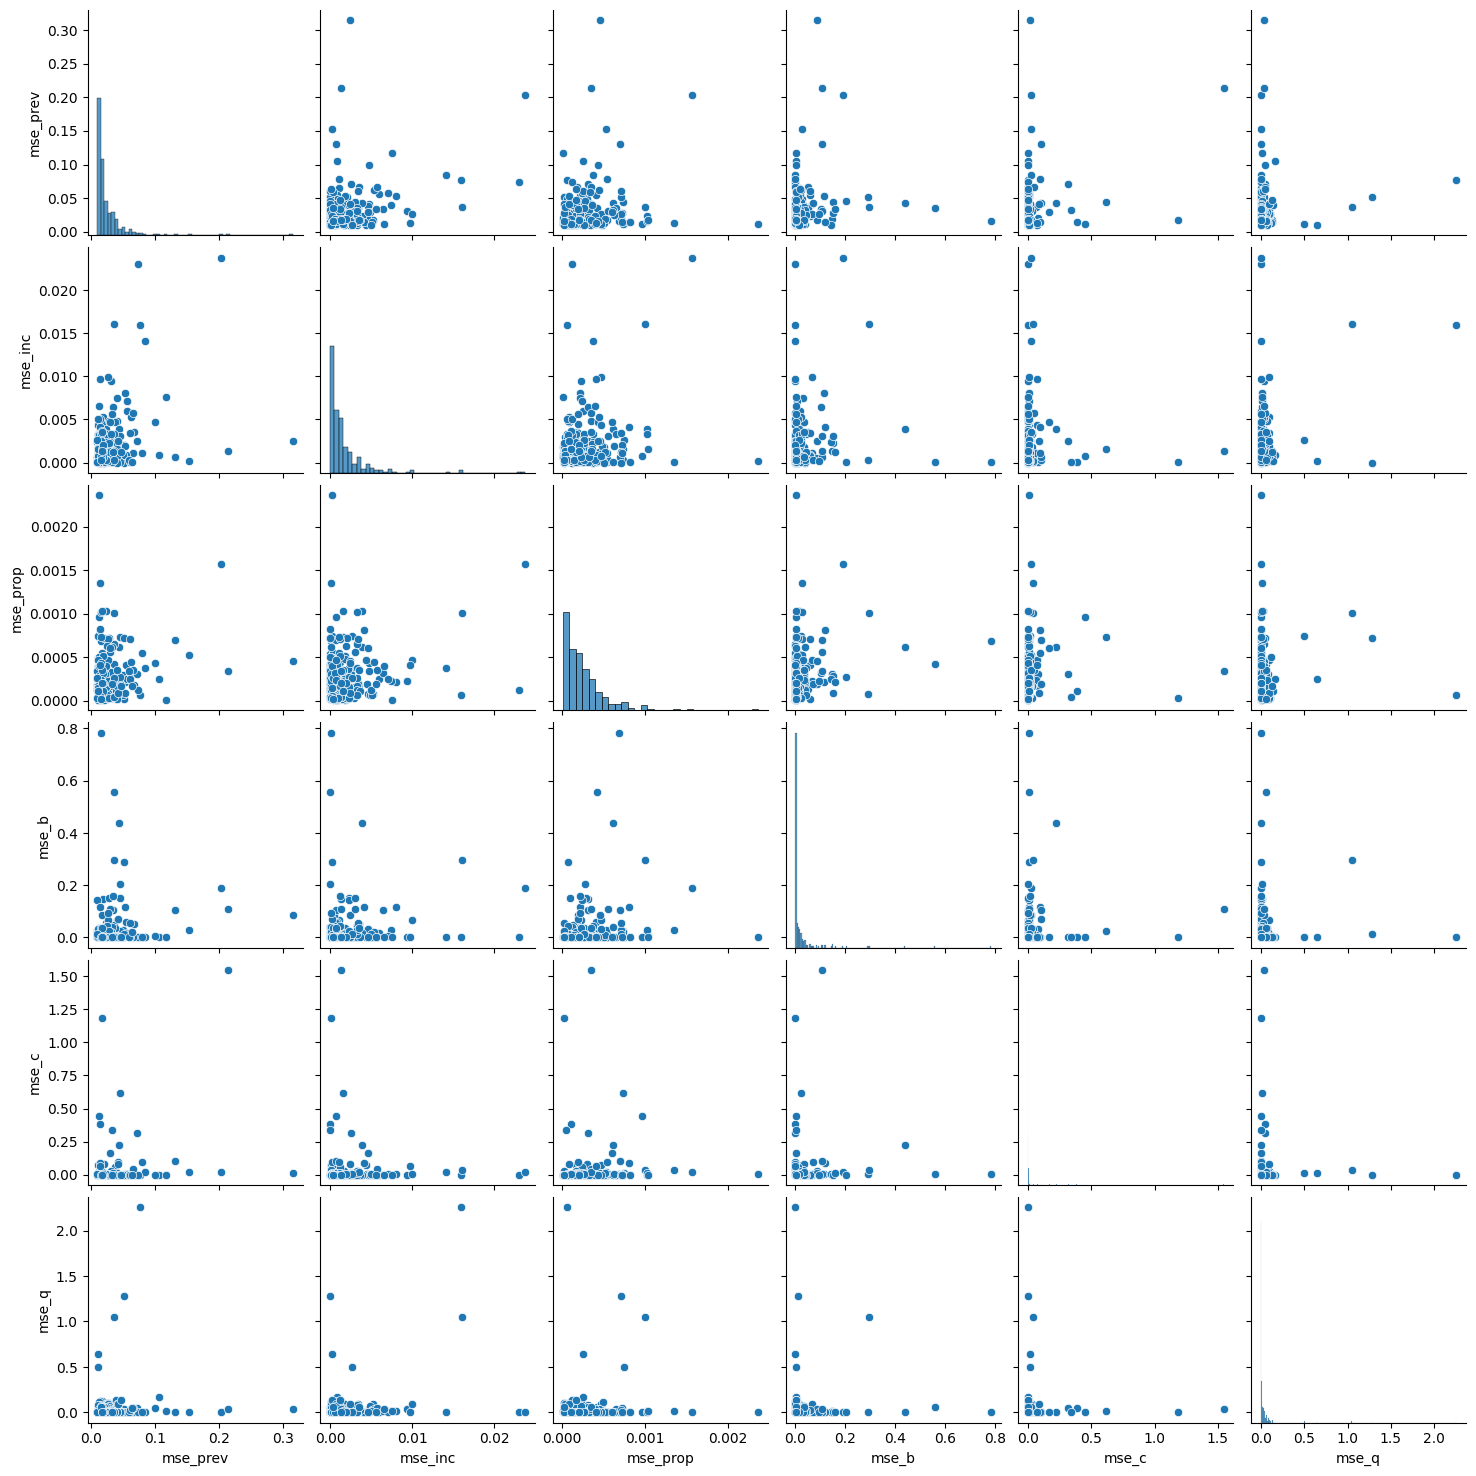

In [175]:
sns.pairplot(loss_data[loss_data.mse_prev > 0.01], vars=['mse_prev','mse_inc','mse_prop','mse_b','mse_c','mse_q'])

In [169]:
losses

Array([[4.70058089e-03, 7.08226990e-04, 4.02504382e-04, 2.26389529e-04,
        9.95024116e-03, 1.15581528e-04],
       [5.97768273e-04, 1.71931154e-03, 8.31089029e-04, 4.45460351e-04,
        1.31235911e-03, 1.05964924e-04],
       [1.41580334e-04, 2.81271476e-04, 1.79993828e-04, 4.35185159e-04,
        2.49129023e-04, 7.45649585e-05],
       ...,
       [4.41210885e-04, 1.52672528e-04, 2.28419577e-03, 9.88081188e-05,
        8.41512115e-05, 2.26549322e-05],
       [1.09989759e-03, 3.64388403e-04, 2.94668103e-04, 3.06293693e-04,
        3.24527267e-04, 3.12179447e-04],
       [9.38341420e-04, 2.54901320e-03, 4.20807203e-04, 3.88748252e-04,
        9.24112338e-04, 6.98690819e-05]], dtype=float64)

In [31]:
import pandas as pd
import seaborn as sns
y_labels = ['prev2-10', 'prev10+', 'inc0-5', 'inc5-15', 'inc15+']

In [32]:
y_hats = {
    'prior_full': y_hat_prior_full,
    'lhs_full': y_hat_lhs_full,
    'prior_fixed': y_hat_prior_fixed,
    'lhs_fixed': y_hat_lhs_fixed
}

NameError: name 'y_hat_prior_full' is not defined

In [38]:
df = pd.concat([
    pd.DataFrame({
        'samples': sample_points[u],
        'RE': jnp.abs(y - y_hat[u])[:, i, j] / y[:, i, j],
        'EIR': EIRs[i],
        'output': y_labels[j],
        'surrogate': s_label
    })
    for i in range(len(EIRs))
    for j in range(len(y_labels))
    for s_label, y_hat in y_hats.items()
    for u in range(len(sample_points))
])

In [84]:
list(datasets.keys())

['X_prior',
 'X_lhs',
 'X_site',
 'y_prior_full',
 'y_lhs_full',
 'y_prior_fixed',
 'y_lhs_fixed']

In [ ]:
y_hat = full_solution_surrogate(
    *lhs_full_surrogate,
    p,
    datasets['X_lhs'],
    datasets['X_site'],
    datasets['y_lhs_full'],
    e,
    a,
)

In [86]:
len(datasets['y_lhs_full']) #x, x_val, mean, std

4

In [83]:
y_shape

(6, 100)

In [91]:
def mses(model, params, x_batched, y_batched):
    # Define a numerically stable log cosh for a single pair (x,y)
    def error(x, y):
        pred = model.apply(params, x)
        diff = y - pred
        return jnp.mean(jnp.square(diff.reshape(y_shape)), axis=1)
    
    # Vectorize the previous to compute the average of the loss on all samples.
    return vmap(error)(x_batched, y_batched)

In [137]:
X_site_mean, X_site_std = datasets['X_site'][2:]
X_mean, X_std = datasets['X_lhs'][2:]
y_mean, y_std = datasets['y_lhs_full'][2:]
x_test = jnp.concatenate([
    datasets['X_site'][1],
    datasets['X_lhs'][1] # validation
], axis=1)
y_test = datasets['y_lhs_full'][1].reshape((x_test.shape[0], -1))
loss_hat = mses(*lhs_full_surrogate, x_test, y_test)

In [138]:
loss_hat.shape

(20000, 6)

<AxesSubplot: xlabel='EIR', ylabel='mse_b'>

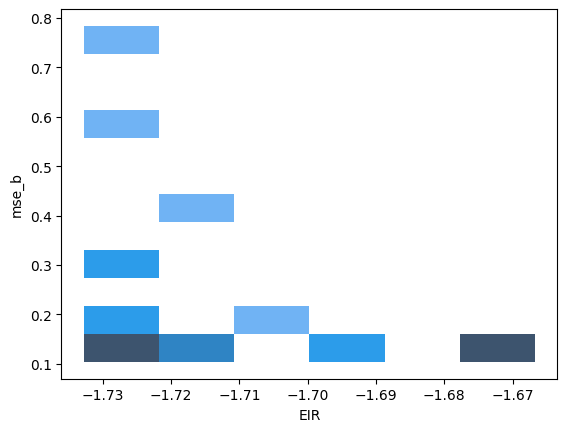

In [140]:
sns.histplot(loss_data[loss_data.mse_b > 0.1], x='EIR', y='mse_b')

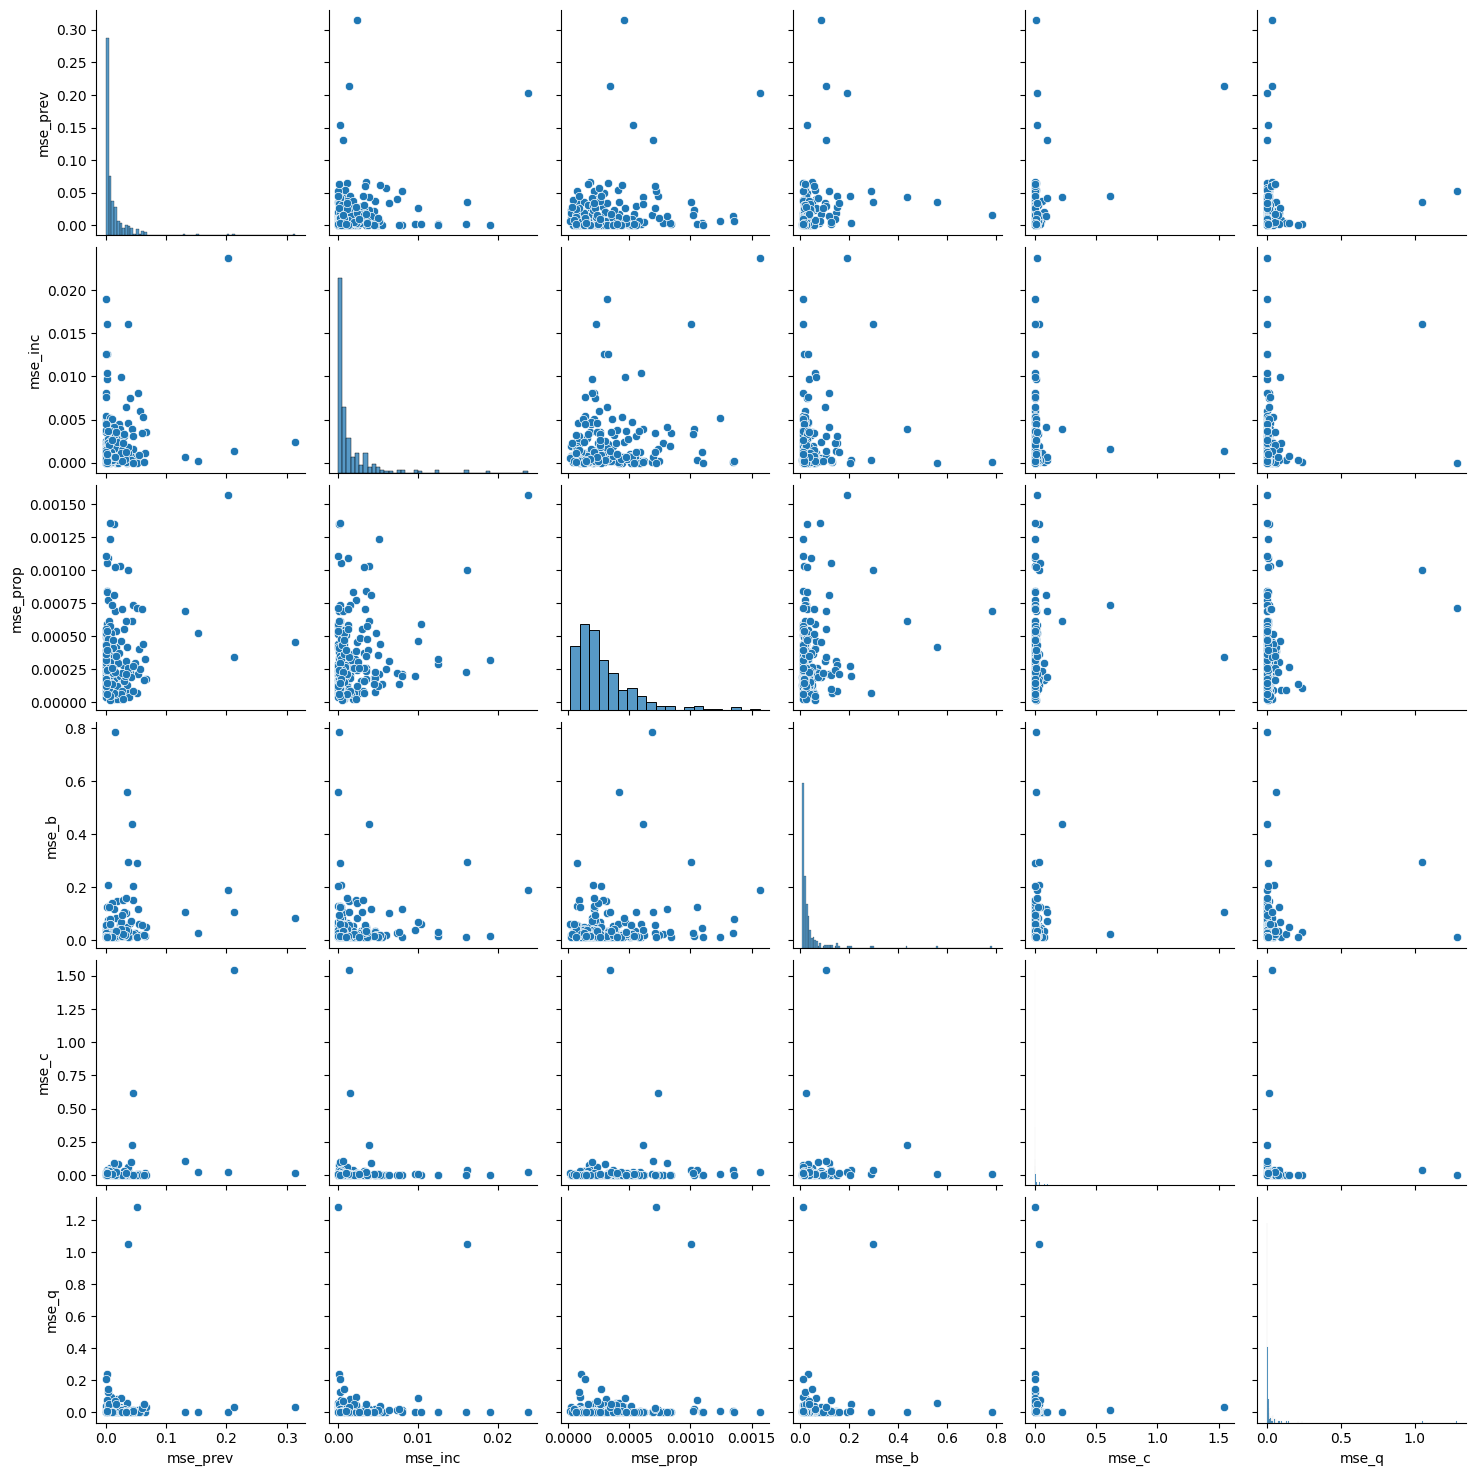

In [126]:
sns.pairplot(loss_data[loss_data.mse_b > 0.01], vars=['mse_prev','mse_inc','mse_prop','mse_b','mse_c','mse_q'])

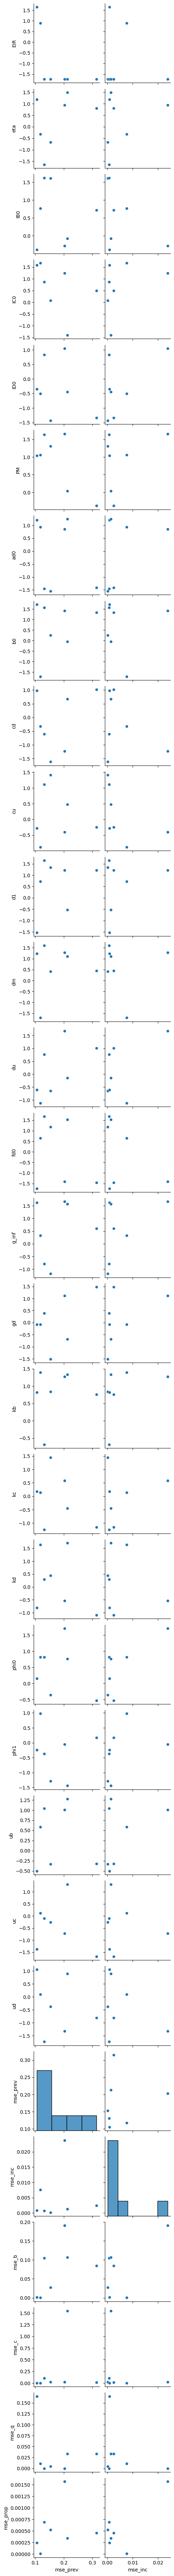

In [145]:
sns.pairplot(loss_data[(loss_data.mse_prev > 0.1)], x_vars=['mse_prev', 'mse_inc'])

(array([1.022511e+06, 3.106500e+05, 1.706800e+05, 1.107600e+05,
        7.840700e+04, 5.876100e+04, 4.542100e+04, 3.583300e+04,
        2.935500e+04, 2.391600e+04, 1.974300e+04, 1.618100e+04,
        1.335900e+04, 1.119000e+04, 9.330000e+03, 7.770000e+03,
        6.581000e+03, 5.336000e+03, 4.329000e+03, 3.664000e+03,
        2.886000e+03, 2.390000e+03, 2.044000e+03, 1.654000e+03,
        1.343000e+03, 1.058000e+03, 8.640000e+02, 6.860000e+02,
        5.600000e+02, 4.710000e+02, 3.330000e+02, 2.530000e+02,
        1.980000e+02, 1.920000e+02, 1.350000e+02, 1.230000e+02,
        1.120000e+02, 8.900000e+01, 9.000000e+01, 5.300000e+01,
        4.300000e+01, 3.700000e+01, 4.500000e+01, 4.200000e+01,
        3.500000e+01, 3.500000e+01, 3.300000e+01, 2.000000e+01,
        2.000000e+01, 3.300000e+01, 3.200000e+01, 2.300000e+01,
        1.700000e+01, 2.300000e+01, 1.400000e+01, 1.200000e+01,
        1.000000e+01, 1.200000e+01, 1.700000e+01, 1.600000e+01,
        1.000000e+01, 1.400000e+01, 1.20

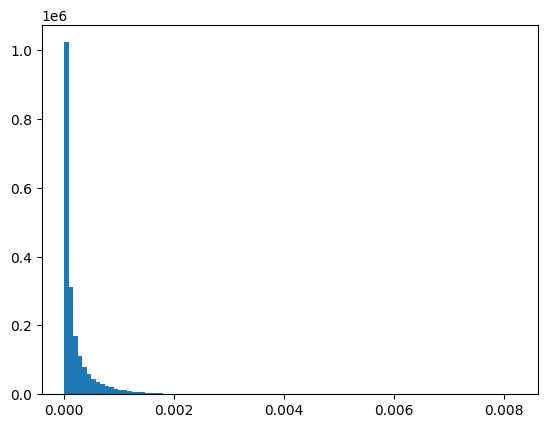

In [116]:
plt.hist(y_i[:,1,:].reshape(-1), bins=100)

(array([9.610e+02, 1.069e+03, 9.440e+02, 7.040e+02, 5.560e+02, 4.850e+02,
        3.910e+02, 3.490e+02, 3.140e+02, 2.820e+02, 2.680e+02, 2.280e+02,
        2.410e+02, 1.920e+02, 1.950e+02, 1.660e+02, 1.600e+02, 1.570e+02,
        1.820e+02, 1.260e+02, 1.370e+02, 1.300e+02, 1.160e+02, 1.040e+02,
        1.100e+02, 1.140e+02, 1.110e+02, 1.010e+02, 8.500e+01, 9.500e+01,
        8.700e+01, 7.700e+01, 6.100e+01, 6.700e+01, 5.800e+01, 5.800e+01,
        4.900e+01, 4.900e+01, 3.800e+01, 3.900e+01, 3.400e+01, 3.100e+01,
        3.400e+01, 2.600e+01, 3.100e+01, 1.700e+01, 2.900e+01, 1.300e+01,
        2.900e+01, 1.200e+01, 2.000e+01, 8.000e+00, 1.100e+01, 1.200e+01,
        5.000e+00, 8.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

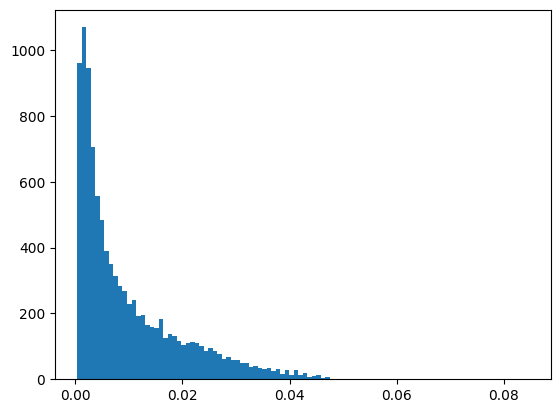

In [121]:
plt.hist(y_i[:100,5,:].reshape(-1), bins=100)

In [57]:
loss_data[loss_data.mse > 0.01]

EIR       eta       IB0       IC0       ID0        PM       ad0  \
12    -1.651476 -0.919863 -0.130464  0.359247 -1.440491 -1.607703 -0.153779   
110    1.705990  0.994796  1.155857  0.206578  0.457765 -0.220888  1.608090   
233    1.617053  0.530451 -1.342379 -0.014494 -0.253270 -1.292567 -0.258857   
235   -1.671037 -1.717960 -0.964906  1.463692  0.852626  0.962365 -1.656604   
647    1.586162  0.236405 -0.838137  0.583552 -1.402933  1.028357 -1.099271   
...         ...       ...       ...       ...       ...       ...       ...   
19685  1.710369  1.131882 -1.701413 -0.209272 -0.636049 -0.499816  0.770399   
19849 -1.131732 -1.562182 -1.156959 -0.719145 -1.381114 -1.551923  0.505598   
19890 -0.167356  1.584101 -1.181916  1.096933  1.726506 -1.148216 -1.106290   
19964 -1.406520 -1.026276 -0.785619 -1.704904 -1.636235  0.767504 -0.534499   
19982  1.457025 -1.113801 -0.542663 -1.279986  1.347797 -1.224644  0.955935   

             b0        cd        cu  ...        gd        kb        kc  \
12     1.682556  0.126971  1.103659  ...  0.773628  1.561678 -1.537754   
110   -1.553646  1.234154  1.730248  ...  0.636299  1.318416  0.889551   
233   -0.911095 -1.499619  1.532425  ...  0.996944 -0.317447 -1.681040   
235    1.731693  1.340278  1.234654  ...  1.487596  0.007062  0.391850   
647   -1.734270  0.924376  1.450873  ... -0.526259 -1.700245 -1.350633   
...         ...       ...       ...  ...       ...       ...       ...   
19685 -1.700592  1.159904 -1.438894  ...  0.090154 -1.495893  0.487525   
19849 -1.677471  0.967534 -0.970912  ... -0.206227 -1.329803 -0.217419   
19890 -1.667907 -0.689466 -1.350970  ... -0.610348 -0.308532  1.341691   
19964  1.228775 -0.965184 -0.765632  ... -1.376000  0.849194  1.458998   
19982 -1.478389 -0.189109  1.588002  ...  0.302328  1.120818 -1.463879   

             kd      phi0      phi1        ub        uc        ud       mse  
12     1.380969 -1.727622  0.153955 -1.259334  0.379924 -1.589645  0.010063  
110    1.385989 -0.634946 -1.010218 -0.151962  1.025435  0.759781  0.010545  
233   -1.577922 -1.595247 -1.419888 -0.610257 -0.044833 -0.243893  0.013306  
235   -0.983213 -0.407356 -0.910114 -1.357535 -1.584525 -0.807474  0.030047  
647   -0.807615  0.146180  1.664862 -0.241842  1.104976  0.312373  0.391661  
...         ...       ...       ...       ...       ...       ...       ...  
19685 -1.407300  0.787237 -1.375735 -1.608714  0.535575 -1.297135  0.016183  
19849  0.170196 -1.055051  0.300376  0.845091  0.403017  0.117730  0.010589  
19890 -1.674856 -0.313373 -1.490115  0.450123 -1.267880 -1.137170  0.013616  
19964 -1.621082  0.177480 -0.438684  0.422596 -0.832930 -0.983620  0.011481  
19982  1.480310  1.447702  1.398965  0.059975  0.510875 -1.315259  0.013564  

[240 rows x 25 columns]

In [54]:
loss_data.sort_values('mse', ascending=False)

EIR       eta       IB0       IC0       ID0        PM       ad0  \
647    1.586162  0.236405 -0.838137  0.583552 -1.402933  1.028357 -1.099271   
19511 -1.731112  1.489485 -0.071474 -1.399276 -0.443052  0.040648  1.241522   
10536 -1.723695  1.399131 -0.530682 -1.589730 -1.377694  0.763295 -0.941481   
13024 -1.731967 -0.139532  1.121976 -1.728954 -1.218628 -1.118855  1.051760   
7616   1.431229 -0.654081  0.189188 -1.640978  0.333674 -0.633606  0.044911   
...         ...       ...       ...       ...       ...       ...       ...   
663   -0.532093 -0.742000  1.430414  1.646576 -0.214949 -1.609402 -1.261812   
19643  0.673432  0.539673 -0.373515 -1.132519 -0.875474 -0.538583 -1.364882   
11396  0.214497 -0.097143 -1.272604 -0.716733  1.105911  0.993046 -1.115158   
18140 -0.663317  0.856301 -0.944128 -0.994183  0.829058  1.574077  0.583811   
12334  0.029750 -1.501383 -1.269481  0.764200 -1.055447  0.239739  0.895087   

             b0        cd        cu  ...        gd        kb        kc  \
647   -1.734270  0.924376  1.450873  ... -0.526259 -1.700245 -1.350633   
19511 -0.037100  0.671005  0.472914  ... -0.684206  1.335849 -0.443808   
10536  1.137080 -0.528793 -1.454049  ... -0.748886  0.377544 -0.407490   
13024  1.017863 -1.194471  0.410691  ...  0.327097 -0.399090 -0.964224   
7616  -1.728264  0.842570  0.371120  ...  1.226404  0.039851  1.175575   
...         ...       ...       ...  ...       ...       ...       ...   
663   -0.964670 -1.003737 -0.381779  ... -1.640957 -0.132341 -1.625469   
19643 -0.597741  1.008890  1.125173  ...  1.654986  0.800861  1.242085   
11396  0.160879  0.591564 -1.593308  ... -0.961531 -0.116938  1.496487   
18140  0.697238  1.162995  0.540201  ...  0.023354 -0.724291 -0.257216   
12334 -0.638381 -0.884652  0.445630  ...  1.013966  0.960801  0.510992   

             kd      phi0      phi1        ub        uc        ud       mse  
647   -0.807615  0.146180  1.664862 -0.241842  1.104976  0.312373  0.391661  
19511  1.705037  0.762951 -1.440494  1.274423  1.307783  0.899338  0.316728  
10536  0.943989  1.581596  0.766093  1.217347 -1.708640  0.219621  0.239384  
13024 -0.872504 -1.523413 -0.611798 -1.376724 -1.563741 -1.183336  0.224631  
7616   0.375834  0.784393 -0.745061 -1.595931  0.692915  0.061515  0.200685  
...         ...       ...       ...       ...       ...       ...       ...  
663   -0.938344 -0.526694 -1.309117  0.958694  1.173831  0.916537  0.000078  
19643 -0.996525 -1.414732  0.266170  0.594502  1.374499  1.574752  0.000075  
11396 -0.123912 -1.197793  1.013488 -0.886149 -0.329607  0.417299  0.000074  
18140  1.114728 -1.032060  1.558054  0.019965  0.798413 -0.028945  0.000067  
12334 -0.642067 -1.374498  1.186833  0.903504 -0.773374 -0.923278  0.000063  

[20000 rows x 25 columns]

In [82]:
y_hat_test = pred_y_full(
    without_obs(prior),
    lambda p, e, a: full_solution_surrogate(
        *lhs_full_surrogate,
        p,
        datasets['X_lhs'],
        datasets['X_site'],
        datasets['y_lhs_full'],
        e,
        a,
    )
)

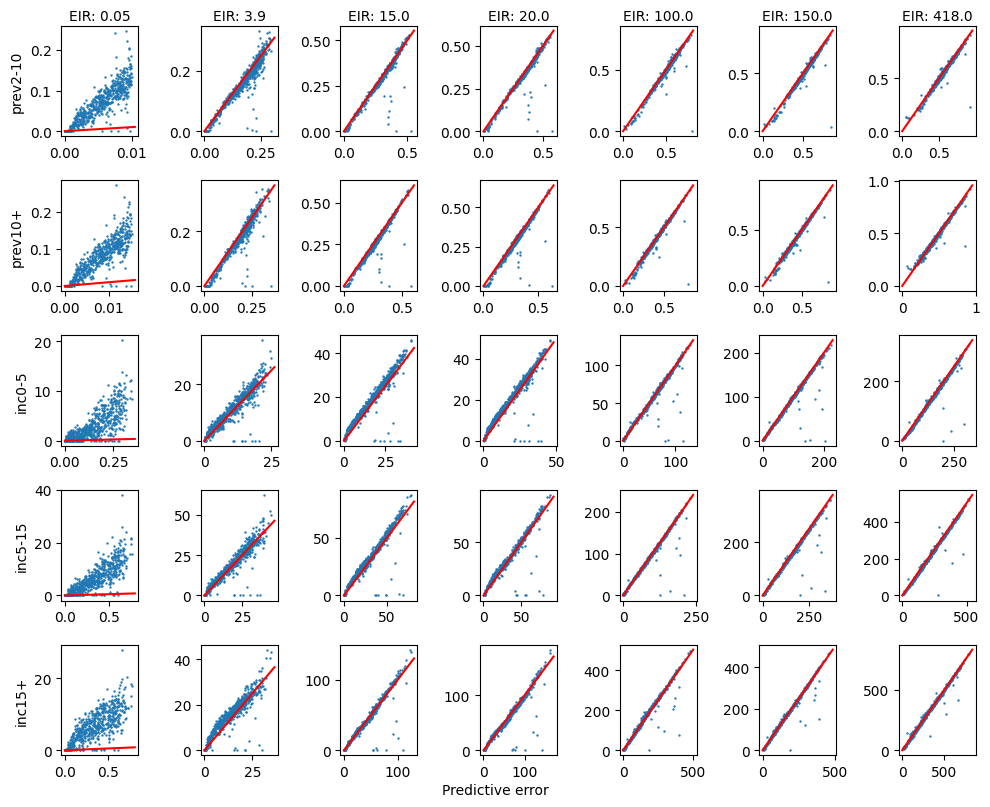

In [83]:
plot_surrogate_predictive_error(y_hat_test)

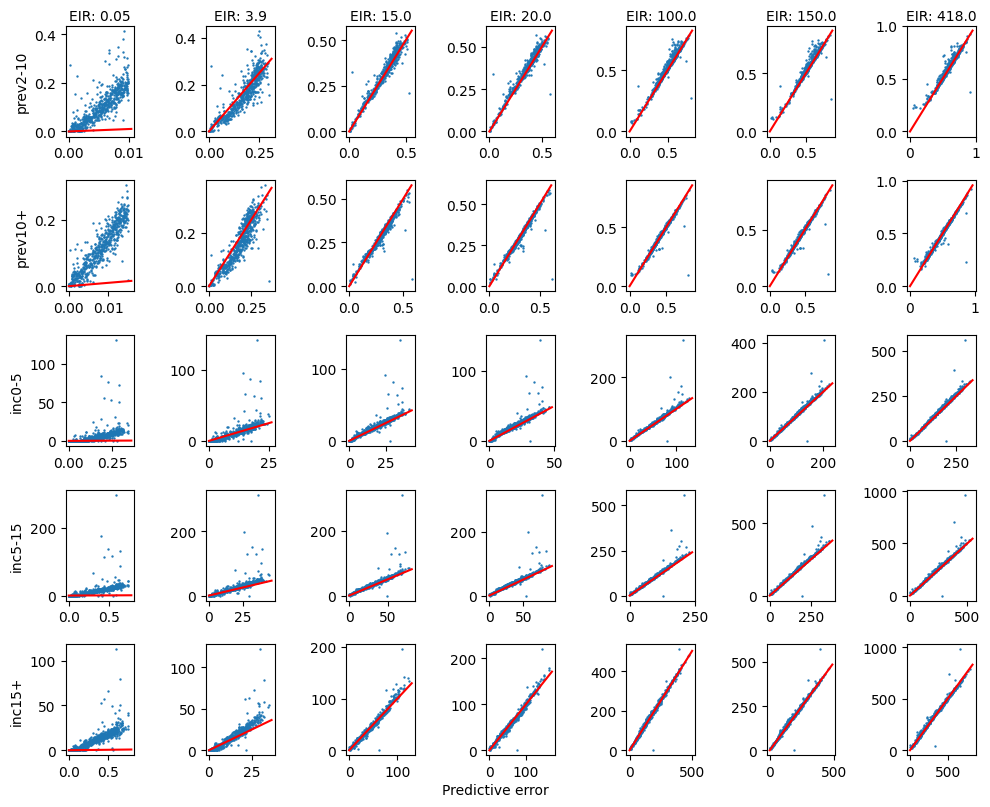

In [45]:
plot_surrogate_predictive_error(y_hat_lhs_full[-1])lhs_full_surrogate

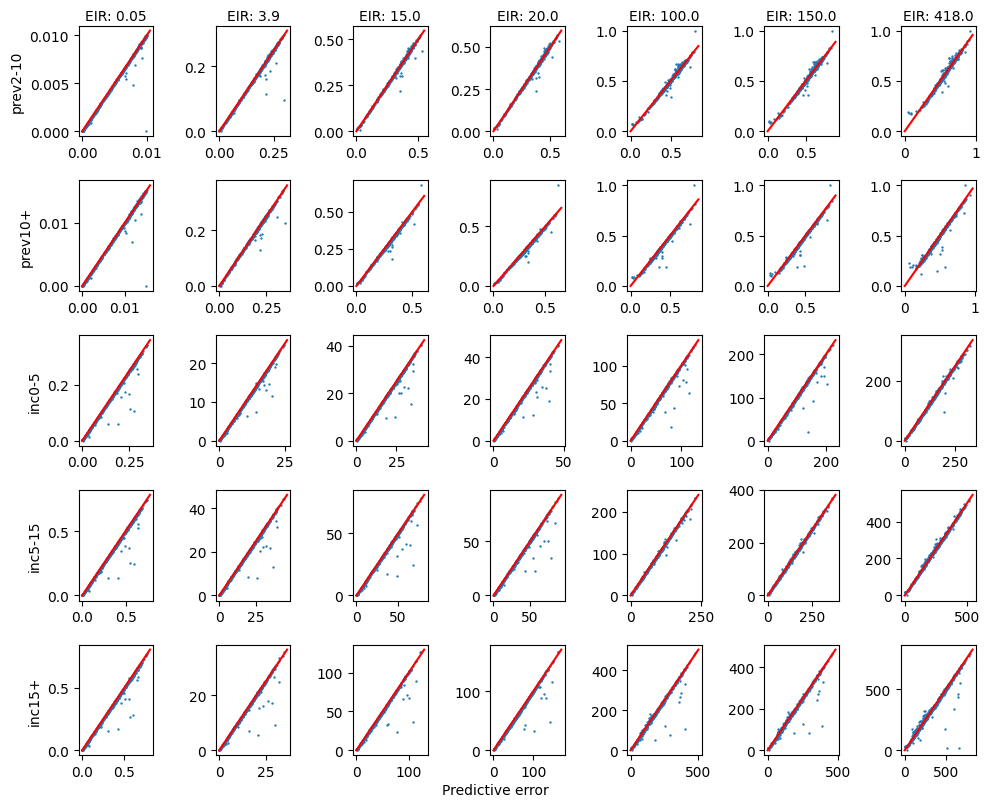

In [46]:
plot_surrogate_predictive_error(y_hat_lhs_fixed[-1])

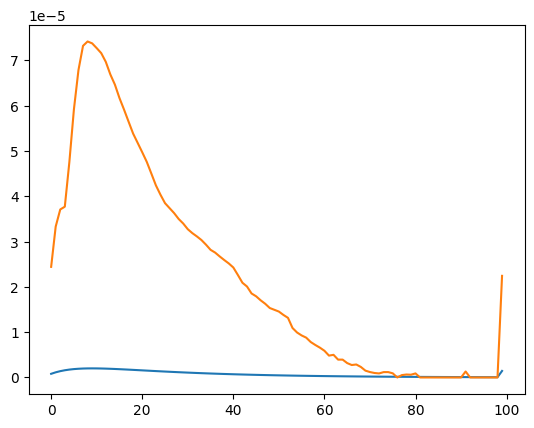

In [49]:
plt.plot(full_solution(true_values, EIRs[0], etas[0])[1])
plt.plot(full_solution_surrogate(
    *surrogates[-1]['lhs_full'],
    without_obs(true_values),
    datasets['X_lhs'],
    datasets['X_site'],
    datasets['y_lhs_full'], EIRs[0], etas[0])[1]
)

# TODO

 * ~Unnormalised prev loss (for survey stats) for easy comparison~
 * ~Is X_site included in training set??~
 * ~Why is unnormalised loss 0?~
 * ~Kernel resarting for surrogate~
 * ~Validation set in training~
 * ~Are the bounds sensible?? No, for EIR, for etas?~
 * Fix props?
 * Good posterior found with low error. However, weird convergence statistics
   * ~constraining neural network?~
   * ~regularisation~
   * fourier net?
   * The density of the true values is much lower in the surrogate!
     * high loss at low EIRs
 * Exchange replica with random walk

In [27]:
n_samples = 100
n_warmup = 100

mcmc = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
    chain_method='vectorized'
)
mcmc.run(key, obs_prev, obs_inc)
mcmc.print_summary(prob=0.7)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:06:51<00:00, 20.06s/it]



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     53.06      9.74     52.85     42.32     62.84   1189.51      1.00
       IC0    104.44     12.79    102.63     90.28    111.54    907.63      1.01
       ID0     24.75      2.24     24.88     23.30     26.13    428.62      1.02
        PM      0.50      0.29      0.50      0.26      0.94   1407.95      1.00
       ad0  11002.00    893.10  10979.82  10328.93  11521.76    264.31      1.03
        b0      0.72      0.05      0.72      0.67      0.76    639.20      1.00
        cd      0.34      0.23      0.30      0.00      0.45   1986.49      1.00
        cu      0.17      0.14      0.13      0.00      0.21   1647.39      1.00
        d1      0.58      0.03      0.59      0.56      0.61    477.79      1.00
        dm    190.18     33.90    197.59    182.13    211.76     42.41      1.26
        du     50.41      4.34     50.00     48.43     51.75    375.42      1.03
       fd0      0.80      0

In [ ]:
surrogate_impl = lambda p, e, a: prev_stats_multisite(p, e, a, full_solution)

In [33]:
def surrogate_impl(p, e, a):
    r = fixed_solution_surrogate(*lhs_fixed_surrogate, p, datasets['X_lhs'], datasets['y_lhs_fixed'])
    return r[:,:2], r[:,2:]

In [34]:
# n_samples = 1000
# n_warmup = 1000

# from numpyro.contrib.tfp.mcmc import RandomWalkMetropolis
# import tensorflow_probability as tfp

# kernel = RandomWalkMetropolis(
#     model,
#     new_state_fn=tfp.substrates.jax.mcmc.random_walk_normal_fn(scale=.04)
# )

n_samples = 100
n_warmup = 100

kernel = NUTS(model)

mcmc_surrogate = MCMC(
    kernel,
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
    chain_method='vectorized' #pmap leads to segfault for some reason (https://github.com/google/jax/issues/13858)
)
mcmc_surrogate.run(key, obs_prev, obs_inc, surrogate_impl)
mcmc_surrogate.print_summary(prob=0.7)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:31<00:00,  2.19it/s]



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     53.35     11.01     52.89     39.80     62.76    155.81      1.04
       IC0    109.16     35.10    108.12     92.11    132.79      8.75      1.58
       ID0     25.36      4.21     25.06     23.73     27.00    262.45      1.04
        PM      0.48      0.28      0.48      0.18      0.85    750.62      1.01
       ad0  10876.32    914.74  10921.62  10125.45  11396.61    248.11      1.03
        b0      0.83      0.07      0.84      0.76      0.91    105.75      1.07
        cd      0.35      0.24      0.31      0.00      0.47    674.89      1.02
        cu      0.16      0.13      0.13      0.00      0.21    736.52      1.02
        d1      0.58      0.03      0.58      0.56      0.61    189.60      1.06
        dm    199.21     22.33    200.06    184.49    215.28   1012.75      1.00
        du     33.08     22.24     48.78      4.65     51.20      8.49      1.88
       fd0      0.50      0

In [61]:
from scipy.stats import ks_2samp
sample_keys = list(posterior_samples.keys())
ks_tests = pd.DataFrame([
    {'statistic': ks_2samp(posterior_samples[k], posterior_samples_surrogate[k]).statistic, 'p-value': ks_2samp(posterior_samples[k], posterior_samples_surrogate[k]).pvalue}
    for k in sample_keys
], sample_keys)

In [65]:
from numpyro.diagnostics import summary
#d = pd.DataFrame(summary(mcmc.get_samples(group_by_chain=True), prob=0.7)).transpose()
d = pd.concat([
    pd.DataFrame(summary(mcmc.get_samples(group_by_chain=True), prob=0.7)).transpose()[['mean', 'std', 'n_eff', 'r_hat']],
    pd.DataFrame(summary(mcmc_surrogate.get_samples(group_by_chain=True), prob=0.7)).transpose()[['mean', 'std', 'n_eff', 'r_hat']],
    ks_tests
], axis=1, keys=['equilibrium solution', 'surrogate', 'KS'])
d['true_value'] = pd.Series(without_obs(true_values)).apply(lambda x: x[0]).astype(float)
print(d.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{equilibrium solution} & \multicolumn{4}{l}{surrogate} & \multicolumn{2}{l}{KS} & true\_value \\
{} &                 mean &    std &   n\_eff & r\_hat &      mean &    std &   n\_eff & r\_hat & statistic & \multicolumn{2}{l}{p-value} \\
\midrule
IB0   &                53.06 &   9.74 & 1189.51 &  1.00 &     53.35 &  11.01 &  155.81 &  1.04 &      0.04 &    0.29 &      58.74 \\
IC0   &               104.44 &  12.79 &  907.63 &  1.01 &    109.16 &  35.10 &    8.75 &  1.58 &      0.22 &    0.00 &     103.93 \\
ID0   &                24.75 &   2.24 &  428.62 &  1.02 &     25.36 &   4.21 &  262.45 &  1.04 &      0.09 &    0.00 &      25.63 \\
PM    &                 0.50 &   0.29 & 1407.95 &  1.00 &      0.48 &   0.28 &  750.62 &  1.01 &      0.04 &    0.54 &       0.73 \\
ad0   &             11002.00 & 893.10 &  264.31 &  1.03 &  10876.32 & 914.74 &  248.11 &  1.03 &      0.06 &    0.05 &   10555.97 \\
b0    &                 0.

/tmp/ipykernel_56934/634325103.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(d.to_latex(float_format="{:0.2f}".format))


In [36]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(
    model,
    posterior_samples
)(key, obs_prev, obs_inc)

In [37]:
posterior_samples_surrogate = mcmc_surrogate.get_samples()
posterior_predictive_surrogate = Predictive(
    model,
    posterior_samples_surrogate
)(key, obs_prev, obs_inc)

In [ ]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior immunity probability function', ha='center')

In [ ]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}'
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        #axs[prev, 0].set_yscale('log')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior pos_M/inc function', ha='center')

In [40]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)
pyro_data_surrogate = az.from_numpyro(
    mcmc_surrogate,
    prior=prior,
    posterior_predictive=posterior_predictive_surrogate
)

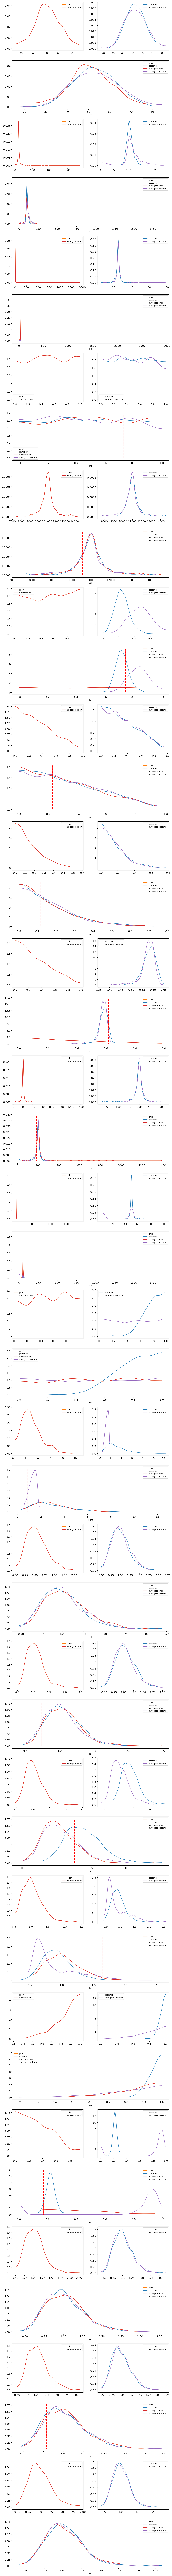

In [41]:
az.rcParams["plot.max_subplots"] = 200
keys = list(pyro_data.prior.data_vars.keys())
axs = az.plot_dist_comparison(pyro_data)
axs = az.plot_dist_comparison(
    pyro_data_surrogate,
    ax=axs
)
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )
    s_prior_lines = [axs[i, 0].get_lines()[1], axs[i, 2].get_lines()[2]]
    s_posterior_lines = [axs[i, 1].get_lines()[1], axs[i, 2].get_lines()[3]]
    for s_prior_line in s_prior_lines:
        s_prior_line.set_color('C3')
        s_prior_line.set_label('surrogate prior')
    for s_posterior_line in s_posterior_lines:
        s_posterior_line.set_color('C4')
        s_posterior_line.set_label('surrogate posterior')
    
    for j in range(3):
        axs[i, j].legend()

In [66]:
def get_curves(params, eirs, etas):
    return vmap(
        vmap(
            full_solution,
            in_axes=[
                {k: 0 for k in params.keys()},
                None,
                None
            ]
        ),
        in_axes=[None, 0, 0]
    )(params, eirs, etas)

In [73]:
posterior_curves_surrogate = get_curves(posterior_samples_surrogate, EIRs, etas)
posterior_curves = get_curves(posterior_samples, EIRs, etas)
prior_curves = get_curves(prior, EIRs, etas)
true_curves = get_curves(without_obs(true_values), EIRs, etas)

Text(0.5, 1, 'Surrogate posterior immunity probability function')

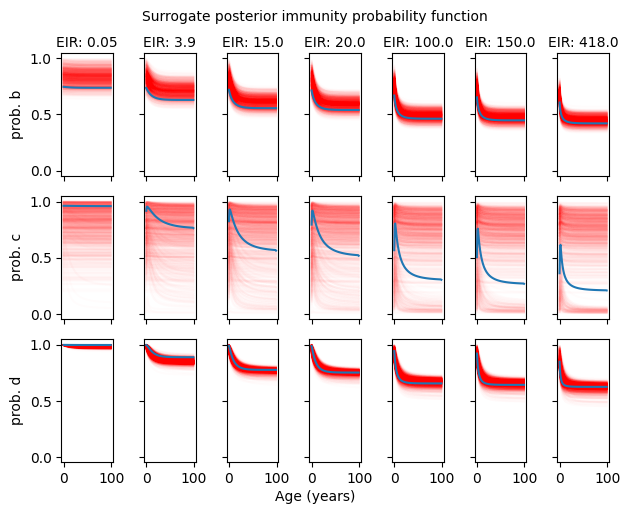

In [75]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves_surrogate[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Surrogate posterior immunity probability function', ha='center')

Text(0.5, 1, 'Posterior immunity probability function')

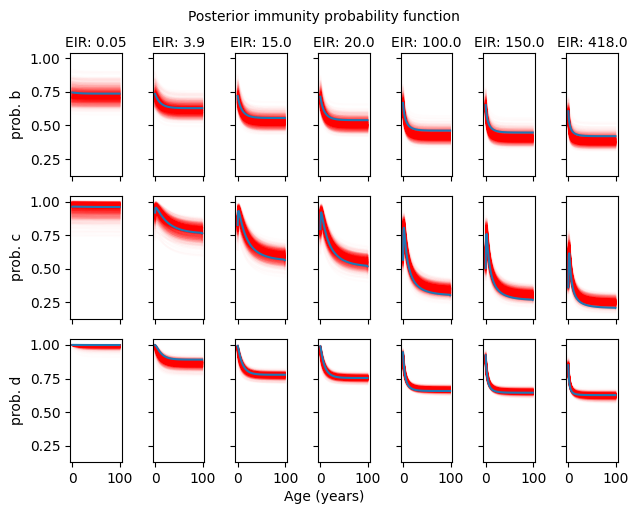

In [76]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(posterior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior immunity probability function', ha='center')

Text(0.5, 1, 'Surrogate posterior pos_M/inc function')

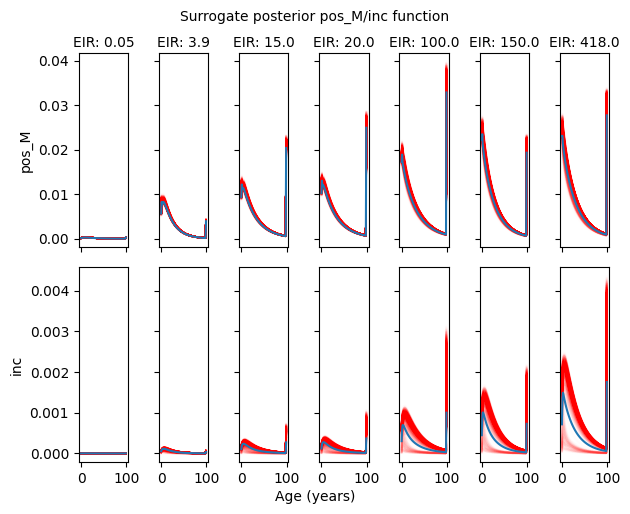

In [77]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(f'EIR: {EIRs[i]}')
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves_surrogate[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Surrogate posterior pos_M/inc function', ha='center')

Text(0.5, 1, 'Posterior pos_M/inc function')

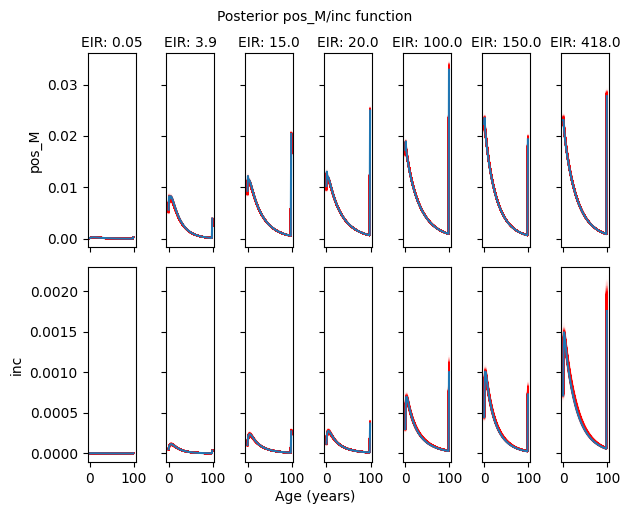

In [78]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(f'EIR: {EIRs[i]}')
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(posterior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Posterior pos_M/inc function', ha='center')

Text(0.5, 1, 'Prior immunity probability function')

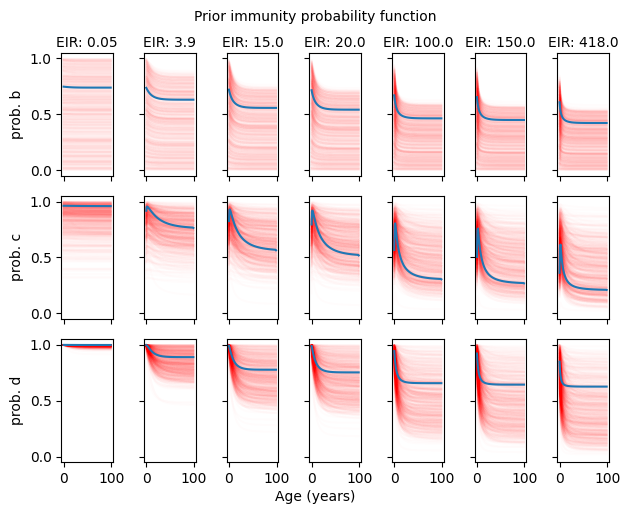

In [80]:
fig, axs = plt.subplots(3, len(EIRs), sharey=True, sharex=True)
imm_labels = ['b', 'c', 'd']
for i in range(len(EIRs)):
    axs[0, i].set_xlabel(
        f'EIR: {EIRs[i]}'
    )
    axs[0, i].xaxis.set_label_position('top')
    for imm in range(3):
        axs[imm, i].plot(prior_curves[i, :, 2+imm, :].T, color='r', alpha=.01)
        axs[imm, i].plot(true_curves[i, 0, 2+imm, :])
        axs[imm, 0].set_ylabel(f'prob. {imm_labels[imm]}')
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior immunity probability function', ha='center')

Text(0.5, 1, 'Prior pos_M/inc function')

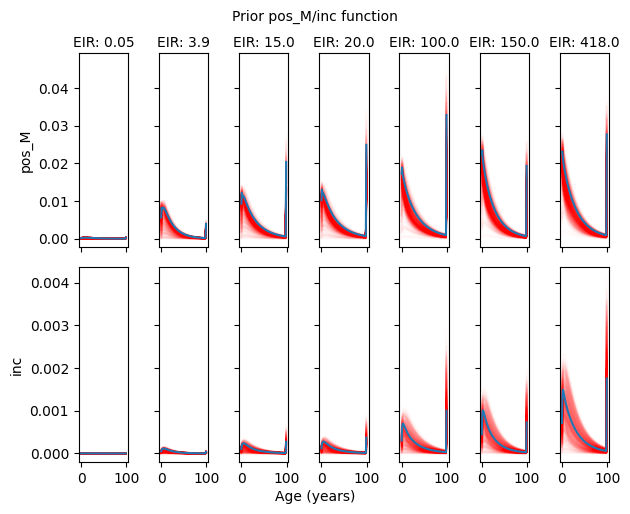

In [79]:
fig, axs = plt.subplots(2, len(EIRs), sharey='row', sharex=True)

prev_labels = ['pos_M', 'inc']
for i in range(len(EIRs)):
    for prev in range(2):
        axs[0, i].set_xlabel(
            f'EIR: {EIRs[i]}',
        )
        axs[0, i].xaxis.set_label_position('top')
        axs[prev, i].plot(prior_curves[i, :, prev, :].T, color='r', alpha=.01)
        axs[prev, i].plot(true_curves[i, 0, prev, :])
        axs[prev, 0].set_ylabel(prev_labels[prev])
        
fig.tight_layout()
fig.text(0.5, 0, 'Age (years)', ha='center')
fig.text(0.5, 1, 'Prior pos_M/inc function', ha='center')

In [93]:
posterior_predictive_surrogate_s = Predictive(
    model,
    posterior_samples_surrogate
)(key, obs_prev, obs_inc, surrogate_impl)

posterior_predictive_s = Predictive(
    model,
    posterior_samples
)(key, obs_prev, obs_inc, surrogate_impl)

In [95]:
p_s_p = jnp.concatenate([
    posterior_predictive_surrogate['obs_prev'],
    posterior_predictive_surrogate['obs_inc']
], axis=3)
p_s_p_s = jnp.concatenate([
    posterior_predictive_surrogate_s['obs_prev'],
    posterior_predictive_surrogate_s['obs_inc']
], axis=3)
pp = jnp.concatenate([
    posterior_predictive['obs_prev'],
    posterior_predictive['obs_inc']
], axis=3)
pp_s = jnp.concatenate([
    posterior_predictive_s['obs_prev'],
    posterior_predictive_s['obs_inc']
], axis=3)

In [96]:
jnp.mean(pp - pp_s, axis=0)

Array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float64)

In [97]:
jnp.mean(p_s_p - p_s_p_s, axis=0)

Array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float64)